In [225]:
from tqdm import tqdm

In [126]:
# basics + plotting
import os, sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 250
plt.rcParams["font.family"] = "sans serif"

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# custom
PROJECT_PATH = '/'.join(os.getcwd().split('/')[:-1])
sys.path.insert(1, PROJECT_PATH)

from utils import (
    data_utils, 
    eval_utils, 
    plotting_utils, 
    train_test_utils
)

from models import (
    mlp
)

In [260]:
import importlib
mlp = importlib.reload(mlp)
data_utils = importlib.reload(data_utils)
eval_utils = importlib.reload(eval_utils)

In [173]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [174]:
with open("../gene_list.txt", 'r') as file:
    gene_list = [x.strip() for x in file.readlines()]

train_dataset, test_dataset = data_utils.load_variation_dataset(data_dir='../data/data',
                                                                gene_list=gene_list,
                                                                data_types=['seq-var-matrix'], 
                                                                phenotypes_path="../data/131338.parquet",
                                                                keep_genes_separate = False)

Fetching FHL1 data ... Done.
Fetching ACTC1 data ... Done.
Fetching ACTN2 data ... Done.
Fetching CSRP3 data ... Done.
Fetching MYBPC3 data ... Done.
Fetching MYH6 data ... Done.
Fetching MYH7 data ... Done.
Fetching MYL2 data ... Done.
Fetching MYL3 data ... Done.
Fetching MYOZ2 data ... Done.
Fetching LDB3 data ... Done.
Fetching TCAP data ... Done.
Fetching TNNC1 data ... Done.
Fetching TNNI3 data ... Done.
Fetching TNNT2 data ... Done.
Fetching TPM1 data ... Done.
Fetching TRIM63 data ... Done.
Fetching PLN data ... Done.
Fetching JPH2 data ... Done.
Fetching FLNC data ... Done.
Fetching ALPK3 data ... Done.
Fetching LMNA data ... Done.
Fetching NEXN data ... Done.
Fetching VCL data ... Done.
Fetching MYOM2 data ... Done.
Fetching CASQ2 data ... Done.
Fetching CAV3 data ... Done.
Fetching MYLK2 data ... Done.
Fetching CRYAB data ... Done.
Combining tables ... Done.
Integrating with phenotypes data ...Done.


In [231]:
train_dataset.dataset.sequences['all'][train_dataset.dataset.seq_id_columns]

AttributeError: 'DataFrame' object has no attribute 'str'

In [254]:
torch.sigmoid(torch.Tensor([[0], [-1], [1]]))

tensor([[0.5000],
        [0.2689],
        [0.7311]])

In [277]:
def train_epoch(model, train_loader, optimizer, loss_fn, log_every=10):
    model.train()
    total_loss = 0
    
    all_labels, all_preds = [],[]
    for i, batch in enumerate(train_loader):
        # move batch dictionary to device
        data_utils.batch_dict_to_device(batch, device)
        labels, features = batch['labels'], batch['seq-var-matrix']
        
        # compute prediction and loss
        preds = model(features)
        loss = loss_fn(preds, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # tracking
        total_loss += loss.item()
        all_labels.append(labels.cpu())
        all_preds.append(preds.flatten().detach().cpu())
        
        # logging
        if (i % log_every == 0):
            print(f"\tBatch {i} | BCE Loss: {loss.item():.4f}")
    
    metrics = eval_utils.get_metrics(torch.cat(all_labels), 
                                     torch.cat(all_preds))
    metrics['loss'] = total_loss
    
    return metrics

def test(model, test_loader, loss_fn):
    model.eval()
    total_loss = 0
    all_labels, all_preds = [],[]
    with torch.no_grad():
        for i, batch in tqdm(enumerate(test_loader)):
            # move batch dictionary to device
            data_utils.batch_dict_to_device(batch, device)
            labels, features = batch['labels'], batch['seq-var-matrix']

            # compute prediction and loss
            preds = model(features)
            loss = loss_fn(preds, labels)

            # tracking
            total_loss += loss.item()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.flatten().detach().cpu())
    
    metrics = eval_utils.get_metrics(torch.cat(all_labels), 
                                     torch.cat(all_preds))
    metrics['loss'] = total_loss
    
    return metrics

def train(model, 
          train_dataset,
          test_dataset, 
          lr=1e-3, 
          n_epochs=10,
          batch_size=256):
    
    train_loader = DataLoader(
        dataset = train_dataset, 
        batch_size = batch_size,
        sampler = WeightedRandomSampler(train_dataset.weights('131338-0.0'), 
                                        num_samples = len(train_dataset)),
        num_workers=12
    )
    
    test_loader = DataLoader(
        dataset = test_dataset,
        batch_size = batch_size,
        num_workers=12
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    track_metrics = {'train':{i:None for i in range(n_epochs)}, 
                     'test': {i:None for i in range(n_epochs)}}
    
    for epoch in range(n_epochs):
        print(f"Epoch #{epoch}:")
        train_metrics = train_epoch(model, 
                                    train_loader, 
                                    optimizer, 
                                    loss_fn, 
                                    log_every=10)
        print("Train metrics:")
        eval_utils.print_metrics(train_metrics)
        test_metrics = test(model, 
                            test_loader, 
                            loss_fn)
        print("Test metrics:")
        eval_utils.print_metrics(test_metrics)
        
        track_metrics['train'][epoch] = train_metrics
        track_metrics['test'][epoch] = test_metrics
    
    return track_metrics
    

In [280]:
params = json.load(open("../params/mlp.json"))
params['model_params']['in_dim'] = train_dataset.dataset.summary.loc['all', 'length']
model = mlp.MLP(**params['model_params'])


In [281]:
model

MLP(
  (fc): Sequential(
    (0): Linear(in_features=12339, out_features=1, bias=True)
  )
)

In [282]:
model_metrics = train(model, 
                      train_dataset,
                      test_dataset, 
                      lr=5e-3, 
                      n_epochs=10,
                      batch_size=256)

Epoch #0:
	Batch 0 | BCE Loss: 0.6930
	Batch 10 | BCE Loss: 0.6920
	Batch 20 | BCE Loss: 0.6912
	Batch 30 | BCE Loss: 0.6904
	Batch 40 | BCE Loss: 0.6849
	Batch 50 | BCE Loss: 0.6894
	Batch 60 | BCE Loss: 0.6782
	Batch 70 | BCE Loss: 0.6772
	Batch 80 | BCE Loss: 0.6835
	Batch 90 | BCE Loss: 0.6813
	Batch 100 | BCE Loss: 0.6807
	Batch 110 | BCE Loss: 0.6786
	Batch 120 | BCE Loss: 0.6695
	Batch 130 | BCE Loss: 0.6796
	Batch 140 | BCE Loss: 0.6768
	Batch 150 | BCE Loss: 0.6793
	Batch 160 | BCE Loss: 0.6778
	Batch 170 | BCE Loss: 0.6798
	Batch 180 | BCE Loss: 0.6732
	Batch 190 | BCE Loss: 0.6758
	Batch 200 | BCE Loss: 0.6704
	Batch 210 | BCE Loss: 0.6804
	Batch 220 | BCE Loss: 0.6744
	Batch 230 | BCE Loss: 0.6735
	Batch 240 | BCE Loss: 0.6594
	Batch 250 | BCE Loss: 0.6649
	Batch 260 | BCE Loss: 0.6676
	Batch 270 | BCE Loss: 0.6749
	Batch 280 | BCE Loss: 0.6664
	Batch 290 | BCE Loss: 0.6734
	Batch 300 | BCE Loss: 0.6607
	Batch 310 | BCE Loss: 0.6602
	Batch 320 | BCE Loss: 0.6753
	Batch 330 

356it [02:02,  2.89it/s]

Test metrics:
	accuracy: 0.737
	precision: 0.007
	recall: 0.268
	f1: 0.014
	AUROC: 0.493
	loss: 222.006
Epoch #1:


	Batch 0 | BCE Loss: 0.6255
	Batch 10 | BCE Loss: 0.6394
	Batch 20 | BCE Loss: 0.6102
	Batch 30 | BCE Loss: 0.6121
	Batch 40 | BCE Loss: 0.6028
	Batch 50 | BCE Loss: 0.6107
	Batch 60 | BCE Loss: 0.6092
	Batch 70 | BCE Loss: 0.6149
	Batch 80 | BCE Loss: 0.5908
	Batch 90 | BCE Loss: 0.6008
	Batch 100 | BCE Loss: 0.5988
	Batch 110 | BCE Loss: 0.6014
	Batch 120 | BCE Loss: 0.6161
	Batch 130 | BCE Loss: 0.6271
	Batch 140 | BCE Loss: 0.6063
	Batch 150 | BCE Loss: 0.6355
	Batch 160 | BCE Loss: 0.6129
	Batch 170 | BCE Loss: 0.6136
	Batch 180 | BCE Loss: 0.6140
	Batch 190 | BCE Loss: 0.6322
	Batch 200 | BCE Loss: 0.6099
	Batch 210 | BCE Loss: 0.6152
	Batch 220 | BCE Loss: 0.6297
	Batch 230 | BCE Loss: 0.6210
	Batch 240 | BCE Loss: 0.6136
	Batch 250 | BCE Loss: 0.6185
	Batch 260 | BCE Loss: 0.6258
	Batch 270 | BCE Loss: 0.6130
	Batch 280 | BCE Loss: 0.6030
	Batch 290 | BCE Loss: 0.6151
	Batch 300 | BCE Loss: 0.6292
	Batch 310 | BCE Loss: 0.6379
	Batch 320 | BCE Loss: 0.6190
	Batch 330 | BCE Loss

356it [01:58,  3.00it/s]

Test metrics:
	accuracy: 0.635
	precision: 0.007
	recall: 0.366
	f1: 0.014
	AUROC: 0.489
	loss: 230.610
Epoch #2:


	Batch 0 | BCE Loss: 0.5844
	Batch 10 | BCE Loss: 0.5866
	Batch 20 | BCE Loss: 0.6203
	Batch 30 | BCE Loss: 0.6016
	Batch 40 | BCE Loss: 0.5962
	Batch 50 | BCE Loss: 0.6046
	Batch 60 | BCE Loss: 0.6078
	Batch 70 | BCE Loss: 0.6209
	Batch 80 | BCE Loss: 0.6245
	Batch 90 | BCE Loss: 0.5833
	Batch 100 | BCE Loss: 0.6034
	Batch 110 | BCE Loss: 0.5848
	Batch 120 | BCE Loss: 0.5901
	Batch 130 | BCE Loss: 0.6406
	Batch 140 | BCE Loss: 0.6047
	Batch 150 | BCE Loss: 0.6138
	Batch 160 | BCE Loss: 0.6171
	Batch 170 | BCE Loss: 0.6020
	Batch 180 | BCE Loss: 0.5771
	Batch 190 | BCE Loss: 0.6103
	Batch 200 | BCE Loss: 0.5935
	Batch 210 | BCE Loss: 0.5966
	Batch 220 | BCE Loss: 0.5860
	Batch 230 | BCE Loss: 0.5906
	Batch 240 | BCE Loss: 0.6022
	Batch 250 | BCE Loss: 0.6103
	Batch 260 | BCE Loss: 0.5728
	Batch 270 | BCE Loss: 0.5920
	Batch 280 | BCE Loss: 0.5855
	Batch 290 | BCE Loss: 0.6273
	Batch 300 | BCE Loss: 0.5916
	Batch 310 | BCE Loss: 0.6039
	Batch 320 | BCE Loss: 0.5942
	Batch 330 | BCE Loss

356it [02:00,  2.94it/s]

Test metrics:
	accuracy: 0.745
	precision: 0.007
	recall: 0.262
	f1: 0.014
	AUROC: 0.484
	loss: 215.292
Epoch #3:


	Batch 0 | BCE Loss: 0.6045
	Batch 10 | BCE Loss: 0.5892
	Batch 20 | BCE Loss: 0.5957
	Batch 30 | BCE Loss: 0.5563
	Batch 40 | BCE Loss: 0.5587
	Batch 50 | BCE Loss: 0.5913
	Batch 60 | BCE Loss: 0.5864
	Batch 70 | BCE Loss: 0.5872
	Batch 80 | BCE Loss: 0.5800
	Batch 90 | BCE Loss: 0.5853
	Batch 100 | BCE Loss: 0.5804
	Batch 110 | BCE Loss: 0.5798
	Batch 120 | BCE Loss: 0.5818
	Batch 130 | BCE Loss: 0.5855
	Batch 140 | BCE Loss: 0.5800
	Batch 150 | BCE Loss: 0.5868
	Batch 160 | BCE Loss: 0.5657
	Batch 170 | BCE Loss: 0.5693
	Batch 180 | BCE Loss: 0.6053
	Batch 190 | BCE Loss: 0.6257
	Batch 200 | BCE Loss: 0.5878
	Batch 210 | BCE Loss: 0.5731
	Batch 220 | BCE Loss: 0.5911
	Batch 230 | BCE Loss: 0.5675
	Batch 240 | BCE Loss: 0.5898
	Batch 250 | BCE Loss: 0.6072
	Batch 260 | BCE Loss: 0.5914
	Batch 270 | BCE Loss: 0.6141
	Batch 280 | BCE Loss: 0.6041
	Batch 290 | BCE Loss: 0.6257
	Batch 300 | BCE Loss: 0.6001
	Batch 310 | BCE Loss: 0.5962
	Batch 320 | BCE Loss: 0.6029
	Batch 330 | BCE Loss

356it [02:10,  2.73it/s]

Test metrics:
	accuracy: 0.770
	precision: 0.008
	recall: 0.238
	f1: 0.015
	AUROC: 0.486
	loss: 209.431
Epoch #4:


	Batch 0 | BCE Loss: 0.6001
	Batch 10 | BCE Loss: 0.5635
	Batch 20 | BCE Loss: 0.5769
	Batch 30 | BCE Loss: 0.5657
	Batch 40 | BCE Loss: 0.5771
	Batch 50 | BCE Loss: 0.5871
	Batch 60 | BCE Loss: 0.5624
	Batch 70 | BCE Loss: 0.5902
	Batch 80 | BCE Loss: 0.5732
	Batch 90 | BCE Loss: 0.5835
	Batch 100 | BCE Loss: 0.5912
	Batch 110 | BCE Loss: 0.5947
	Batch 120 | BCE Loss: 0.6086
	Batch 130 | BCE Loss: 0.5980
	Batch 140 | BCE Loss: 0.5975
	Batch 150 | BCE Loss: 0.5708
	Batch 160 | BCE Loss: 0.6225
	Batch 170 | BCE Loss: 0.5718
	Batch 180 | BCE Loss: 0.5881
	Batch 190 | BCE Loss: 0.5927
	Batch 200 | BCE Loss: 0.5582
	Batch 210 | BCE Loss: 0.5855
	Batch 220 | BCE Loss: 0.5847
	Batch 230 | BCE Loss: 0.6057
	Batch 240 | BCE Loss: 0.5831
	Batch 250 | BCE Loss: 0.5964
	Batch 260 | BCE Loss: 0.5872
	Batch 270 | BCE Loss: 0.5889
	Batch 280 | BCE Loss: 0.5738
	Batch 290 | BCE Loss: 0.5783
	Batch 300 | BCE Loss: 0.5759
	Batch 310 | BCE Loss: 0.5830
	Batch 320 | BCE Loss: 0.5831
	Batch 330 | BCE Loss

356it [02:04,  2.87it/s]

Test metrics:
	accuracy: 0.737
	precision: 0.007
	recall: 0.257
	f1: 0.014
	AUROC: 0.479
	loss: 212.631
Epoch #5:


	Batch 0 | BCE Loss: 0.5938
	Batch 10 | BCE Loss: 0.5874
	Batch 20 | BCE Loss: 0.5940
	Batch 30 | BCE Loss: 0.5954
	Batch 40 | BCE Loss: 0.5971
	Batch 50 | BCE Loss: 0.5787
	Batch 60 | BCE Loss: 0.6260
	Batch 70 | BCE Loss: 0.6062
	Batch 80 | BCE Loss: 0.5794
	Batch 90 | BCE Loss: 0.5688
	Batch 100 | BCE Loss: 0.6191
	Batch 110 | BCE Loss: 0.6131
	Batch 120 | BCE Loss: 0.5795
	Batch 130 | BCE Loss: 0.5643
	Batch 140 | BCE Loss: 0.5775
	Batch 150 | BCE Loss: 0.6149
	Batch 160 | BCE Loss: 0.5856
	Batch 170 | BCE Loss: 0.6191
	Batch 180 | BCE Loss: 0.5895
	Batch 190 | BCE Loss: 0.5526
	Batch 200 | BCE Loss: 0.5830
	Batch 210 | BCE Loss: 0.5694
	Batch 220 | BCE Loss: 0.5815
	Batch 230 | BCE Loss: 0.5548
	Batch 240 | BCE Loss: 0.5830
	Batch 250 | BCE Loss: 0.6037
	Batch 260 | BCE Loss: 0.5983
	Batch 270 | BCE Loss: 0.6094
	Batch 280 | BCE Loss: 0.5860
	Batch 290 | BCE Loss: 0.5732
	Batch 300 | BCE Loss: 0.5922
	Batch 310 | BCE Loss: 0.5803
	Batch 320 | BCE Loss: 0.5958
	Batch 330 | BCE Loss

356it [02:00,  2.95it/s]

Test metrics:
	accuracy: 0.768
	precision: 0.007
	recall: 0.237
	f1: 0.014
	AUROC: 0.483
	loss: 209.474
Epoch #6:


	Batch 0 | BCE Loss: 0.5766
	Batch 10 | BCE Loss: 0.5789
	Batch 20 | BCE Loss: 0.5500
	Batch 30 | BCE Loss: 0.6260
	Batch 40 | BCE Loss: 0.5638
	Batch 50 | BCE Loss: 0.5986
	Batch 60 | BCE Loss: 0.5719
	Batch 70 | BCE Loss: 0.5960
	Batch 80 | BCE Loss: 0.5815
	Batch 90 | BCE Loss: 0.6051
	Batch 100 | BCE Loss: 0.5645
	Batch 110 | BCE Loss: 0.5942
	Batch 120 | BCE Loss: 0.5785
	Batch 130 | BCE Loss: 0.5342
	Batch 140 | BCE Loss: 0.5956
	Batch 150 | BCE Loss: 0.6206
	Batch 160 | BCE Loss: 0.5688
	Batch 170 | BCE Loss: 0.6015
	Batch 180 | BCE Loss: 0.5638
	Batch 190 | BCE Loss: 0.5712
	Batch 200 | BCE Loss: 0.5853
	Batch 210 | BCE Loss: 0.5745
	Batch 220 | BCE Loss: 0.5495
	Batch 230 | BCE Loss: 0.6381
	Batch 240 | BCE Loss: 0.5648
	Batch 250 | BCE Loss: 0.5606
	Batch 260 | BCE Loss: 0.5805
	Batch 270 | BCE Loss: 0.5939
	Batch 280 | BCE Loss: 0.5327
	Batch 290 | BCE Loss: 0.5788
	Batch 300 | BCE Loss: 0.5799
	Batch 310 | BCE Loss: 0.5855
	Batch 320 | BCE Loss: 0.5830
	Batch 330 | BCE Loss

356it [02:06,  2.81it/s]


Test metrics:
	accuracy: 0.714
	precision: 0.007
	recall: 0.297
	f1: 0.015
	AUROC: 0.487
	loss: 214.041
Epoch #7:
	Batch 0 | BCE Loss: 0.5802
	Batch 10 | BCE Loss: 0.6083
	Batch 20 | BCE Loss: 0.5856
	Batch 30 | BCE Loss: 0.5980
	Batch 40 | BCE Loss: 0.5549
	Batch 50 | BCE Loss: 0.5677
	Batch 60 | BCE Loss: 0.5535
	Batch 70 | BCE Loss: 0.5658
	Batch 80 | BCE Loss: 0.5774
	Batch 90 | BCE Loss: 0.5511
	Batch 100 | BCE Loss: 0.5919
	Batch 110 | BCE Loss: 0.5672
	Batch 120 | BCE Loss: 0.5374
	Batch 130 | BCE Loss: 0.6126
	Batch 140 | BCE Loss: 0.5489
	Batch 150 | BCE Loss: 0.5513
	Batch 160 | BCE Loss: 0.5660
	Batch 170 | BCE Loss: 0.5911
	Batch 180 | BCE Loss: 0.5766
	Batch 190 | BCE Loss: 0.5802
	Batch 200 | BCE Loss: 0.5730
	Batch 210 | BCE Loss: 0.6223
	Batch 220 | BCE Loss: 0.5660
	Batch 230 | BCE Loss: 0.6118
	Batch 240 | BCE Loss: 0.5713
	Batch 250 | BCE Loss: 0.6023
	Batch 260 | BCE Loss: 0.5426
	Batch 270 | BCE Loss: 0.5724
	Batch 280 | BCE Loss: 0.5810
	Batch 290 | BCE Loss: 0.60

356it [01:59,  2.99it/s]

Test metrics:
	accuracy: 0.707
	precision: 0.007
	recall: 0.300
	f1: 0.014
	AUROC: 0.484
	loss: 214.374
Epoch #8:


	Batch 0 | BCE Loss: 0.5632
	Batch 10 | BCE Loss: 0.5831
	Batch 20 | BCE Loss: 0.5689
	Batch 30 | BCE Loss: 0.5795
	Batch 40 | BCE Loss: 0.5655
	Batch 50 | BCE Loss: 0.5551
	Batch 60 | BCE Loss: 0.5572
	Batch 70 | BCE Loss: 0.5841
	Batch 80 | BCE Loss: 0.5641
	Batch 90 | BCE Loss: 0.5854
	Batch 100 | BCE Loss: 0.5864
	Batch 110 | BCE Loss: 0.5656
	Batch 120 | BCE Loss: 0.5882
	Batch 130 | BCE Loss: 0.5617
	Batch 140 | BCE Loss: 0.5707
	Batch 150 | BCE Loss: 0.5554
	Batch 160 | BCE Loss: 0.5641
	Batch 170 | BCE Loss: 0.5854
	Batch 180 | BCE Loss: 0.5891
	Batch 190 | BCE Loss: 0.5373
	Batch 200 | BCE Loss: 0.5924
	Batch 210 | BCE Loss: 0.5843
	Batch 220 | BCE Loss: 0.5583
	Batch 230 | BCE Loss: 0.5945
	Batch 240 | BCE Loss: 0.5591
	Batch 250 | BCE Loss: 0.5801
	Batch 260 | BCE Loss: 0.5991
	Batch 270 | BCE Loss: 0.5623
	Batch 280 | BCE Loss: 0.5624
	Batch 290 | BCE Loss: 0.5924
	Batch 300 | BCE Loss: 0.5634
	Batch 310 | BCE Loss: 0.5771
	Batch 320 | BCE Loss: 0.5756
	Batch 330 | BCE Loss

356it [02:03,  2.89it/s]

Test metrics:
	accuracy: 0.797
	precision: 0.007
	recall: 0.206
	f1: 0.014
	AUROC: 0.483
	loss: 203.336
Epoch #9:


	Batch 0 | BCE Loss: 0.5631
	Batch 10 | BCE Loss: 0.6011
	Batch 20 | BCE Loss: 0.5917
	Batch 30 | BCE Loss: 0.6102
	Batch 40 | BCE Loss: 0.5859
	Batch 50 | BCE Loss: 0.5394
	Batch 60 | BCE Loss: 0.5424
	Batch 70 | BCE Loss: 0.5772
	Batch 80 | BCE Loss: 0.6147
	Batch 90 | BCE Loss: 0.5716
	Batch 100 | BCE Loss: 0.6033
	Batch 110 | BCE Loss: 0.5474
	Batch 120 | BCE Loss: 0.5386
	Batch 130 | BCE Loss: 0.5453
	Batch 140 | BCE Loss: 0.5561
	Batch 150 | BCE Loss: 0.5556
	Batch 160 | BCE Loss: 0.6152
	Batch 170 | BCE Loss: 0.5614
	Batch 180 | BCE Loss: 0.5881
	Batch 190 | BCE Loss: 0.5631
	Batch 200 | BCE Loss: 0.5763
	Batch 210 | BCE Loss: 0.5531
	Batch 220 | BCE Loss: 0.5915
	Batch 230 | BCE Loss: 0.5906
	Batch 240 | BCE Loss: 0.5925
	Batch 250 | BCE Loss: 0.5666
	Batch 260 | BCE Loss: 0.5980
	Batch 270 | BCE Loss: 0.5133
	Batch 280 | BCE Loss: 0.5537
	Batch 290 | BCE Loss: 0.5893
	Batch 300 | BCE Loss: 0.6045
	Batch 310 | BCE Loss: 0.5837
	Batch 320 | BCE Loss: 0.5897
	Batch 330 | BCE Loss

356it [02:02,  2.90it/s]

Test metrics:
	accuracy: 0.729
	precision: 0.007
	recall: 0.260
	f1: 0.014
	AUROC: 0.483
	loss: 211.681


In [299]:
def plot_metrics(metrics, axes):
    metric_types = list(metrics['train'][0].keys())
    for mt,ax in zip(metric_types, axes.flatten()):
        ax.plot([x[mt] for x in model_metrics['train'].values()])
        ax.plot([x[mt] for x in model_metrics['test'].values()])
        ax.set_title(mt)
    axes[0,0].legend(['train', 'test'])

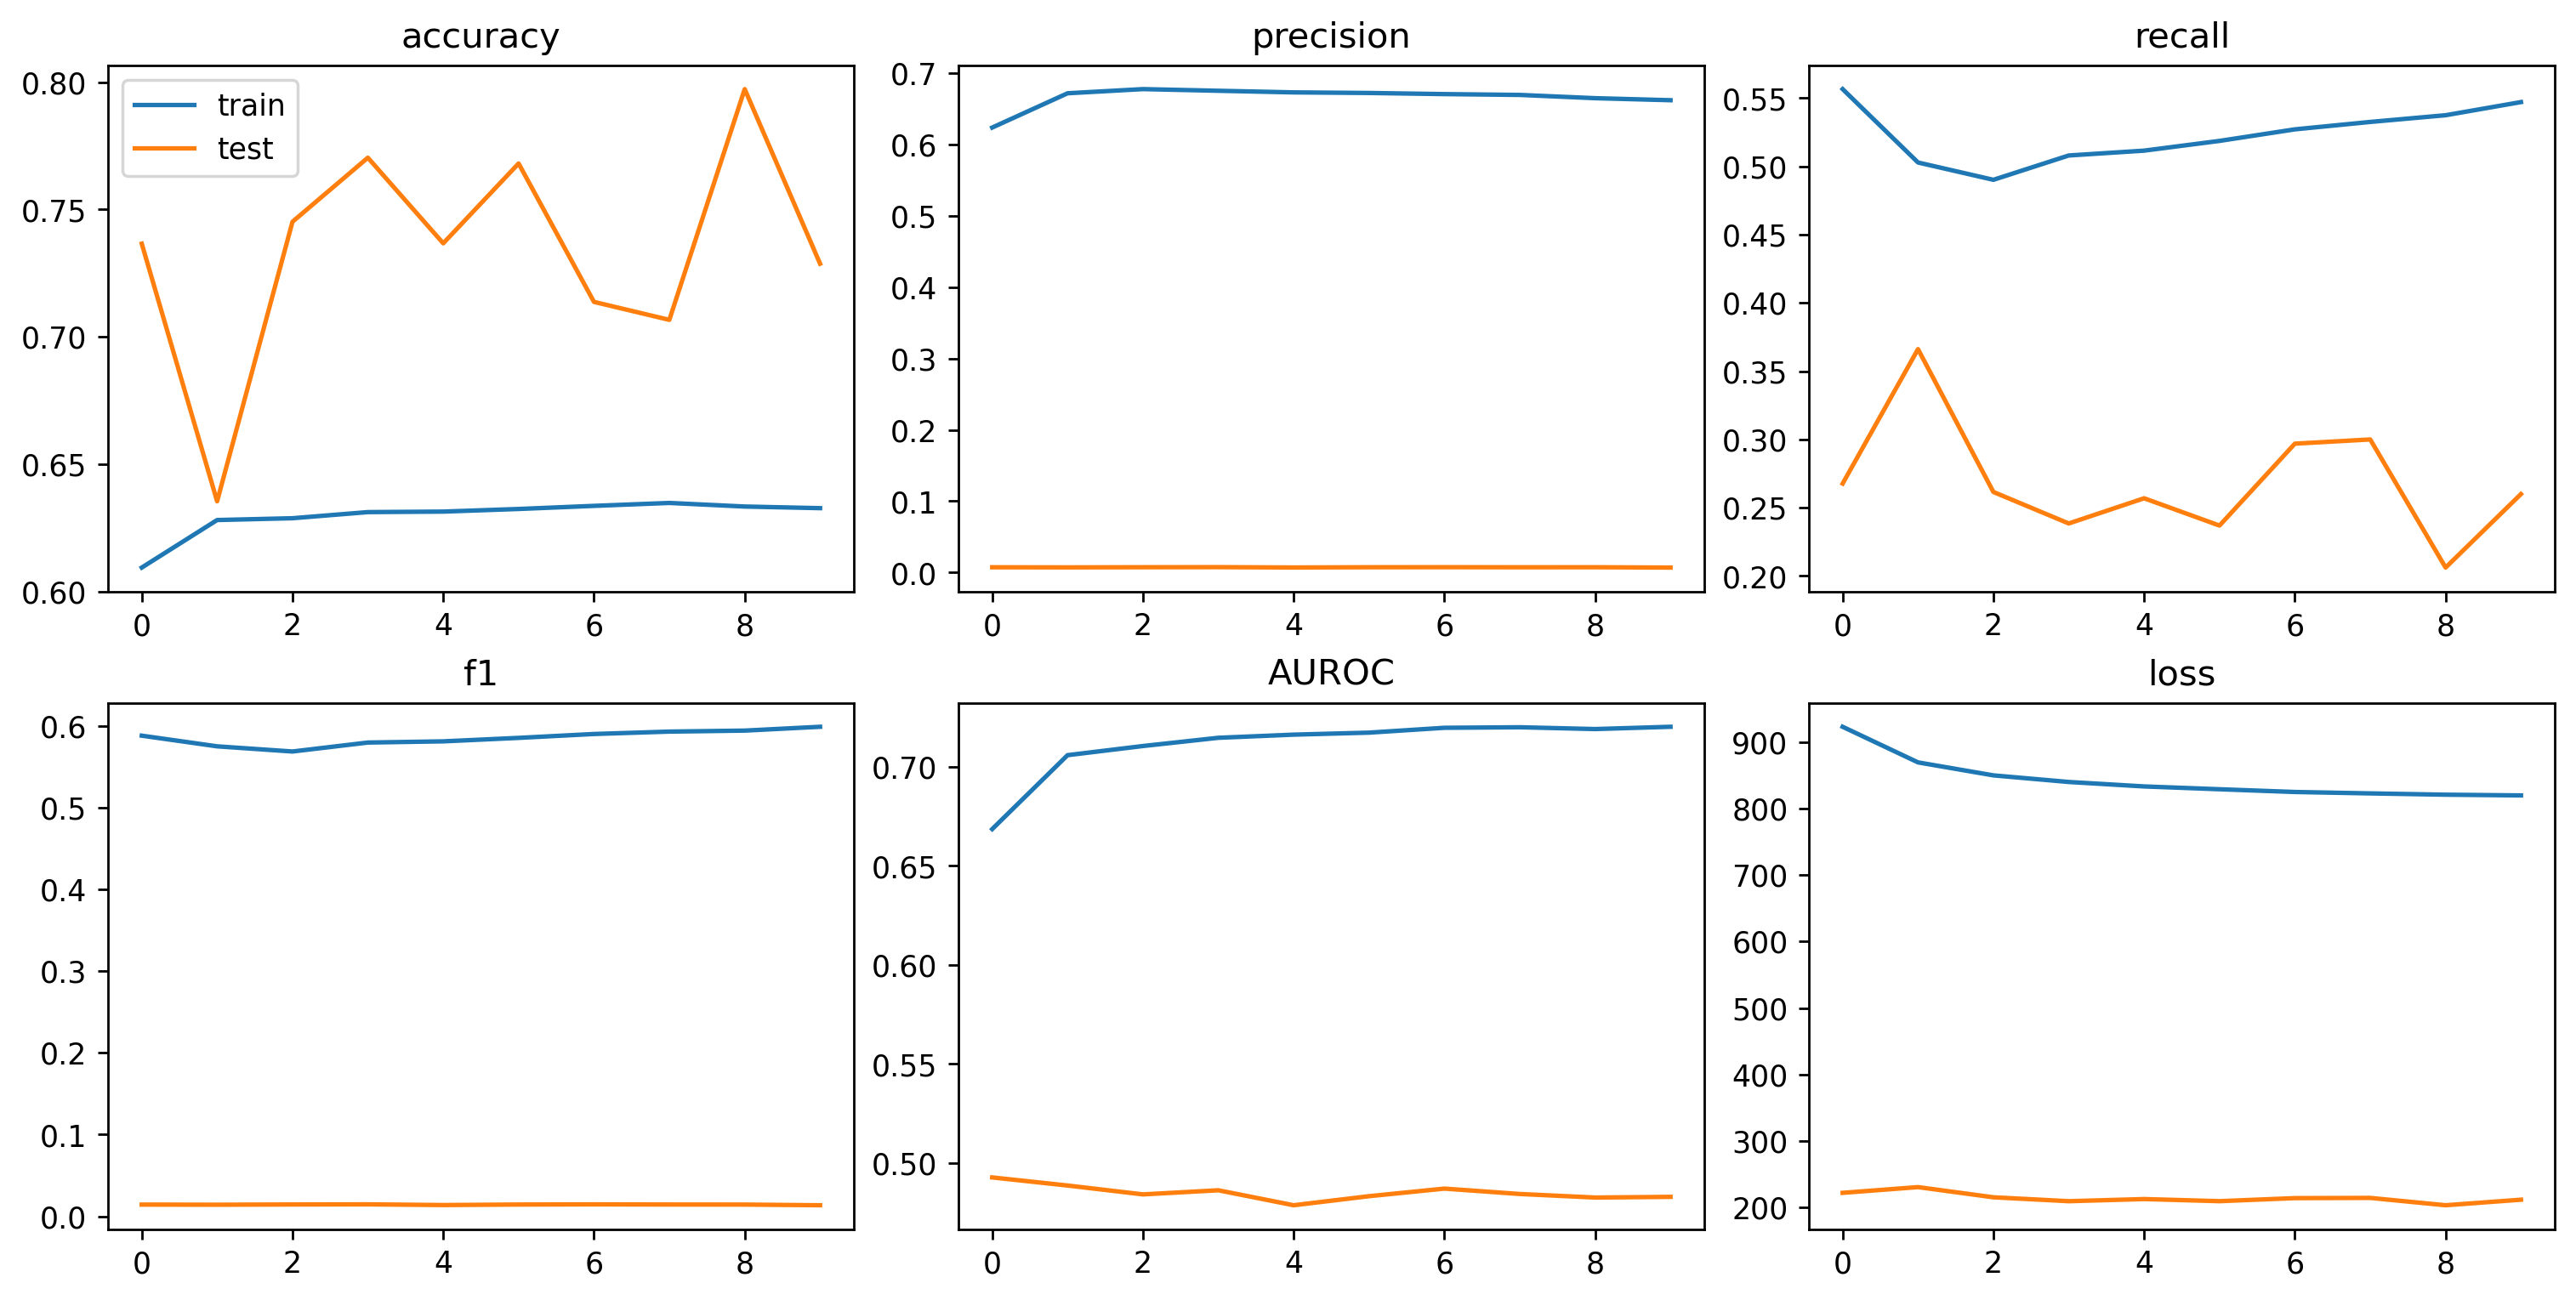

In [301]:
fig, axes = plt.subplots(2,3,figsize=(12,6), constrained_layout=True)

plot_metrics(model_metrics, axes)
# fig.savefig('../figures/lr_initial.png')